#### load in modules

In [3]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#### read in processed data

In [18]:
# read in process data on test budget needed by each agent to find all infected nodes (ttt)
with open('./example_data/tests_to_threshold.csv', 'r') as f:
    seed_agent_ttt = {}
    for index, line in enumerate(f):
        if index == 0:
            continue
        seed, agent, ttt = line.strip().split(',')
        seed = int(seed)
        ttt = int(ttt)
        if seed in seed_agent_ttt:
            seed_agent_ttt[seed][agent] = ttt
        else:
            seed_agent_ttt[seed] = { agent: ttt }

In [19]:
# read in combined metric (AUC) data
seed_agent_metrics_df = pd.read_csv('./example_data/seed_agent_metrics.csv', sep=',')

In [20]:
# read in combined metadata
seed_agent_metadata = json.load(open('./example_data/seed_agent_metadata.json', 'r'))
seed_agent_metadata = { int(k): v for k, v in seed_agent_metadata.items() }

#### calculate median tests-to-threshold (ttt) for each policy

In [21]:
# get ttts for each policy
policy_ttts = {}
for seed, agent_ttt in seed_agent_ttt.items():
    for agent_id, ttt in agent_ttt.items():
        agent_policy = seed_agent_metadata[seed][agent_id]['allocation_policy']
        if agent_policy not in policy_ttts:
            policy_ttts[agent_policy] = [ttt]
        else:
            policy_ttts[agent_policy].append(ttt)

In [22]:
# calculate median ttt for each policy
policy_median_ttt = { policy: np.median(ttt) for policy, ttt in policy_ttts.items() }
print(policy_median_ttt)
# max. test budget  = 81 (median ttt for reactive_infected)

{'node_entropy': 139.0, 'reactive_infected': 81.0, 'bald': 148.0, 'random': 166.0, 'le': 137.0}


#### compute IQR for each policy at each test budget

In [23]:
# compute median AUCs for each policy at each test budget (across different seeds and initial_nodes)
# (ignoring NaNs, only problematic at large test budgets)
seed_agent_metrics_df = seed_agent_metrics_df.rename(columns={'time': 'test_iter'})
avg_aucs_df = seed_agent_metrics_df.groupby(['test_iter', 'active_policy']).apply(lambda x: np.nanmedian(x['auc'])).reset_index(name='avg_auc')
# calculate 25th and 75th percentiles
# (ignoring NaNs, only problematic at large test budgets)
p25_aucs_df = seed_agent_metrics_df.groupby(['test_iter', 'active_policy']).apply(lambda x: np.nanpercentile(x['auc'], 25)).reset_index(name='p25_auc')
p75_aucs_df = seed_agent_metrics_df.groupby(['test_iter', 'active_policy']).apply(lambda x: np.nanpercentile(x['auc'], 75)).reset_index(name='p75_auc')
# merge
avg_aucs_df = avg_aucs_df.merge(p25_aucs_df, on=['test_iter', 'active_policy'])
avg_aucs_df = avg_aucs_df.merge(p75_aucs_df, on=['test_iter', 'active_policy'])

# add median ttt for each policy
avg_aucs_df['median_ttt'] = avg_aucs_df.apply(lambda x: policy_median_ttt[x['active_policy']], axis=1)

/var/folders/q9/0h40wkyj4s79vh8zt8z0yssm0000gp/T/ipykernel_79145/1069903329.py:4: RuntimeWarning: All-NaN slice encountered
  avg_aucs_df = seed_agent_metrics_df.groupby(['test_iter', 'active_policy']).apply(lambda x: np.nanmedian(x['auc'])).reset_index(name='avg_auc')
/Users/user/Library/Python/3.9/lib/python/site-packages/numpy/lib/nanfunctions.py:1384: RuntimeWarning: All-NaN slice encountered
  return _nanquantile_unchecked(
/Users/user/Library/Python/3.9/lib/python/site-packages/numpy/lib/nanfunctions.py:1384: RuntimeWarning: All-NaN slice encountered
  return _nanquantile_unchecked(


#### plot AUCs (using example data with only 5 simulated outbreaks)

In [24]:
# define the colors for the different policies
policy_colors = {
    'random': '#151515',
    'reactive_infected': '#6494AA',
    'degree_central': '#C47B93',
    'pagerank_central': '#7072B1',
    'node_entropy': '#BE953E',
    'bald': '#90A959',
    'le': '#9A3526'
}

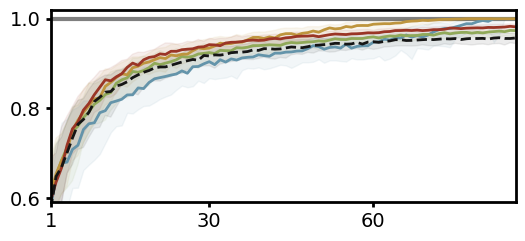

In [26]:
# plot average AUCs up to max. test budget (median ttt for reactive_infected)
fig, ax = plt.subplots(figsize=(6, 2.5))

# max test budget
max_test_budget = 81

# set z-orders for different policies (higher z-order means on top)
policy_zorder = {
    'random': 14,
    'reactive_infected': 6,
    'node_entropy': 10,
    'bald': 9,
    'le': 12,
}

# plot shaded regions (IQR) first
for policy in avg_aucs_df['active_policy'].unique():
    policy_df = avg_aucs_df[avg_aucs_df['active_policy'] == policy]
    ax.fill_between(policy_df['test_iter'], policy_df['p25_auc'], policy_df['p75_auc'], color=policy_colors[policy], alpha=0.08, zorder=-99)

# then plot median AUCs
for policy in avg_aucs_df['active_policy'].unique():
    policy_df = avg_aucs_df[avg_aucs_df['active_policy'] == policy]
    ax.plot(policy_df['test_iter'], policy_df['avg_auc'], label=policy, color=policy_colors[policy],
            linestyle='--' if policy in ['random', 'reactive_infected_v2'] else '-',
            linewidth=2, alpha=1, zorder=30+policy_zorder[policy])
    
ax.set_xlim([1, max_test_budget+5])
ax.set_ylim([0.59, 1.02])
# set x ticks and labels
xticklabels = list(np.arange(0, max_test_budget, 30))
xticklabels[0] = 1
ax.set_xticks(xticklabels)

# horizontal line at y=1
ax.axhline(1, color='black', linestyle='-', linewidth=3, alpha=0.5)

# add thick border
for spine in ax.spines.values():
    spine.set_linewidth(2)
    spine.set_zorder(100)

# adjust thickness of ticks on x and y axes
ax.xaxis.set_tick_params(width=2)
ax.yaxis.set_tick_params(width=2)

# adjust fontsize of tick labels
ax.tick_params(axis='both', which='major', labelsize=14)
ax.tick_params(axis='both', which='minor', labelsize=14)

plt.show()

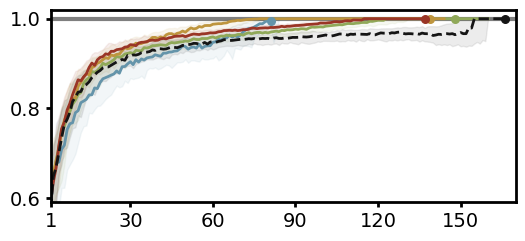

In [36]:
# plot average AUCs (full results)
fig, ax = plt.subplots(figsize=(6, 2.5))

# max test budget
max_test_budget = 168

# set z-orders for different policies (higher z-order means on top)
policy_zorder = {
    'random': 14,
    'reactive_infected': 6,
    'node_entropy': 10,
    'bald': 9,
    'le': 12,
}

# plot shaded regions (IQR) first
for policy in avg_aucs_df['active_policy'].unique():
    policy_df = avg_aucs_df[avg_aucs_df['active_policy'] == policy]
    ax.fill_between(policy_df['test_iter'], policy_df['p25_auc'], policy_df['p75_auc'], color=policy_colors[policy], alpha=0.08, zorder=-99)

# then plot median AUCs
for policy in avg_aucs_df['active_policy'].unique():
    policy_df = avg_aucs_df[avg_aucs_df['active_policy'] == policy]
    ax.plot(policy_df['test_iter'], policy_df['avg_auc'], label=policy, color=policy_colors[policy],
            linestyle='--' if policy in ['random', 'reactive_infected_v2'] else '-',
            linewidth=2, alpha=1, zorder=30+policy_zorder[policy])
    
# add circle to indicate median ttt for each policy
for policy in avg_aucs_df['active_policy'].unique():
    median_ttt = policy_median_ttt[policy]
    policy_df = avg_aucs_df[(avg_aucs_df['active_policy'] == policy)]
    median_auc = policy_df[(policy_df['test_iter'] == median_ttt)]['avg_auc'].values[0]
    ax.scatter(median_ttt, median_auc, color=policy_colors[policy], s=30, zorder=70+policy_zorder[policy])

ax.set_xlim([1, 170])
ax.set_ylim([0.59, 1.02])
# set x ticks and labels
xticklabels = list(np.arange(0, max_test_budget, 30))
xticklabels[0] = 1
ax.set_xticks(xticklabels)

# horizontal line at y=1
ax.axhline(1, color='black', linestyle='-', linewidth=3, alpha=0.5)

# add thick border
for spine in ax.spines.values():
    spine.set_linewidth(2)
    spine.set_zorder(100)

# adjust thickness of ticks on x and y axes
ax.xaxis.set_tick_params(width=2)
ax.yaxis.set_tick_params(width=2)

# adjust fontsize of tick labels
ax.tick_params(axis='both', which='major', labelsize=14)
ax.tick_params(axis='both', which='minor', labelsize=14)

plt.show()

#### top-ranking frequencies

In [46]:
# only evaluate up to max test budget
max_test_budget = 81
seed_agent_metrics_ranked_df = seed_agent_metrics_df[seed_agent_metrics_df.test_iter <= max_test_budget].copy()

In [47]:
# function to rank agents within each group and assign fractional scores when multiple agents share the top rank
def rank_and_assign_fractional_scores(df):
    # sort agents by AUC in descending order
    df['rank'] = df['auc'].rank(method='min', ascending=False)

    # identify agents with the top rank
    top_rank = df['rank'].min()
    top_agents = df[df['rank'] == top_rank]

    # number of agents sharing the top score
    num_top_agents = len(top_agents)

    # assign fractional score to top-ranked agents
    fractional_score = 1 / num_top_agents

    # initialize fractional_score column
    df['fractional_score'] = df['rank']

    # assign fractional scores to top-ranked agents
    df.loc[df['rank'] == top_rank, 'fractional_score'] = fractional_score

    return df

# rank agents within each group (seed, initial_node) at each test iteration
seed_agent_metrics_ranked_df = seed_agent_metrics_ranked_df.groupby(['test_iter', 'seed', 'initial_node'],
                                                                    group_keys=False).apply(rank_and_assign_fractional_scores)


In [54]:
# now take only agents with fractional_score <= 1 (i.e. top-ranked agents)
seed_agent_metrics_ranked_df = seed_agent_metrics_ranked_df[seed_agent_metrics_ranked_df['fractional_score'] <= 1]
# for each (test_iter, policy), sum fractional scores
policy_fractional_score_sum = seed_agent_metrics_ranked_df.groupby(['test_iter', 'active_policy']).apply(
    lambda x: x['fractional_score'].sum()).reset_index(name='policy_fractional_score')
# divide sums by number of unique (seed, initial_node) pairs
seed_initial_node_pairs = len(seed_agent_metrics_ranked_df[['seed', 'initial_node']].drop_duplicates())
policy_fractional_score_sum['policy_fractional_score'] /= seed_initial_node_pairs

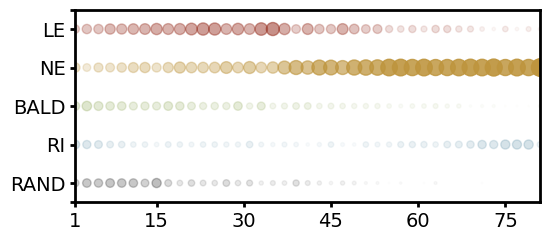

In [72]:
# draw circles to indicate top-ranking frequencies for each policy at every nth test iterations
fig, ax = plt.subplots(figsize=(6, 2.5))

# get frequencies for each policy at every nth test iteration
n_iters = 2
test_iters = list(range(1, max_test_budget + 1, n_iters))
# order of policies to plot (bottom to top)
policy_order = ['random', 'reactive_infected', 'bald', 'node_entropy', 'le']
policy_freqs = { policy: [] for policy in policy_order }
# iterate over test_iters and policies
for test_iter in test_iters:
    for policy in policy_order:
        policy_freq = policy_fractional_score_sum[
            (policy_fractional_score_sum['test_iter'] == test_iter) &
            (policy_fractional_score_sum['active_policy'] == policy)]['policy_fractional_score'].values
        if len(policy_freq) == 0: # test_iter when no agents of this policy were top-ranked
            policy_freqs[policy].append(0)
        else:
            policy_freqs[policy].append(policy_freq[0])

# get min/max policy_freq
min_freq = min([min(policy_freqs[policy]) for policy in policy_order])
max_freq = max([max(policy_freqs[policy]) for policy in policy_order])
# set min/max sizes and alphas for circles
min_s = 0
max_s = 160
min_alpha = 0
max_alpha = 1
for policy in policy_order:
    policy_index = policy_order.index(policy)
    # normalise policy_freqs[policy] to [min_s, max_s]
    normalised_s = [min_s + (max_s - min_s) * (x - min_freq) / (max_freq - min_freq) for x in policy_freqs[policy]]
    # normalise policy_freqs[policy] to [min_alpha, max_alpha]
    normalised_alpha = [min_alpha + (max_alpha - min_alpha) * (x - min_freq) / (max_freq - min_freq) for x in policy_freqs[policy]]
    ax.scatter(test_iters, [policy_index+1] * len(test_iters),
               color=policy_colors[policy], s=normalised_s, alpha=normalised_alpha, marker='o')

# set x, y limits
ax.set_ylim([0.5, len(policy_order) + 0.5])
ax.set_yticks([0.5] + list(np.arange(1, len(policy_order) + 1)) + [len(policy_order) + 0.5])
# ax.set_yticklabels([])
ax.set_yticklabels(['', 'RAND', 'RI', 'BALD', 'NE', 'LE', ''])
ax.set_xlim([1, max_test_budget])
# set x ticks and labels
xticklabels = list(np.arange(0, policy_median_ttt['reactive_infected'], 15))
xticklabels[0] = 1
ax.set_xticks(xticklabels)

# add thick border
for spine in ax.spines.values():
    spine.set_linewidth(2)
    spine.set_zorder(100)

# adjust thickness of ticks on x and y axes
ax.xaxis.set_tick_params(width=2)
ax.yaxis.set_tick_params(width=2)

# adjust fontsize of tick labels
ax.tick_params(axis='both', which='major', labelsize=14)
ax.tick_params(axis='both', which='minor', labelsize=14)

plt.show()

#### compute aggregated top-ranking policies (different levels of test budget)

In [73]:
# function to divide a given range [1, max_test_budget] into three equal parts (where possible)
def split_into_three(max_num):
    # generate the list of integers from 1 to max_num
    numbers = list(range(1, max_num + 1))

    # calculate the base size of each part
    base_size = max_num // 3
    remainder = max_num % 3

    # assign numbers to the three parts
    part1 = numbers[:base_size + (1 if remainder > 0 else 0)]
    part2 = numbers[base_size + (1 if remainder > 0 else 0) : 2 * base_size + (2 if remainder > 1 else 1)]
    part3 = numbers[2 * base_size + (2 if remainder > 1 else 1):]

    return part1, part2, part3

In [81]:
# divide [1, max_test_budget] into three parts
low_budget_range, medium_budget_range, high_budget_range = split_into_three(max_test_budget)
budget_ranges = {
    'low': low_budget_range,
    'medium': medium_budget_range,
    'high': high_budget_range
}

In [96]:
# for each budget range, find the policy with the highest frequency of being top-ranked and store both the frequency and the policy
top_policies = {}
for budget_range, budget_range_values in budget_ranges.items():
    policy_fractional_score_sum_subset = policy_fractional_score_sum[
        policy_fractional_score_sum['test_iter'].isin(budget_range_values)]
    # average the fractional scores across the budget range
    policy_fractional_score_sum_subset = policy_fractional_score_sum_subset.groupby('active_policy').apply(
        lambda x: x['policy_fractional_score'].mean()).reset_index(name='policy_fractional_score')
    # find the policy with the highest frequency of being top-ranked
    top_policy = policy_fractional_score_sum_subset[
        policy_fractional_score_sum_subset['policy_fractional_score'] == policy_fractional_score_sum_subset[
            'policy_fractional_score'].max()]['active_policy'].values[0]
    # store the frequency and the policy
    top_policies[budget_range] = (policy_fractional_score_sum_subset['policy_fractional_score'].max(), top_policy)

In [113]:
# print (note that these are based on the example data, not the full data)
for budget_range, (frequency, policy) in top_policies.items():
    print(f'{budget_range} test budget: {policy.upper()} with top-ranking frequency of {frequency}')

low test budget: LE with top-ranking frequency of 0.30800000000000005
medium test budget: NODE_ENTROPY with top-ranking frequency of 0.49228571428571416
high test budget: NODE_ENTROPY with top-ranking frequency of 0.721076923076923
